## Preprocessed 2 Data (로그 변환 O, PCA X)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

## 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/MyDrive/BigMart/Train_preprocessed10.csv')
df.drop(['Unnamed: 0'],axis = 1,inplace = True)
df.columns

Index(['Item_Weight', 'Item_Outlet_Sales', 'Item_Fat_Content_0',
       'Item_Fat_Content_1', 'Outlet_Size_0', 'Outlet_Size_1',
       'Outlet_Location_Type_0', 'Outlet_Location_Type_1', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'New_Item_Type_0', 'New_Item_Type_1',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Item_Type_0', 'Item_Type_1',
       'Item_Type_2', 'Item_Type_3', 'Item_Type_4', 'Item_Type_5',
       'Item_Type_6', 'Item_Type_7', 'Item_Type_8', 'Item_Type_9',
       'Item_Type_10', 'Item_Type_11', 'Item_Type_12', 'Item_Type_13',
       'Item_Type_14', 'log_Item_Visibility', 'Type1_Tear1', 'Type1_Tear2',
       'log_Item_MRP', 'log_Outlet_Years'],
      dtype='object')

In [ ]:
X =df.drop(columns=['Item_Outlet_Sales'], axis=1)
y =df['Item_Outlet_Sales']

## StandardScaler 표준화 시켜주기

In [ ]:
from sklearn.preprocessing import StandardScaler

cont_vars = ['Item_Weight', 'log_Item_Visibility', 'log_Item_MRP', 'log_Outlet_Years']
cat_vars = ['Item_Fat_Content_0',
       'Item_Fat_Content_1', 'Outlet_Size_0', 'Outlet_Size_1',
       'Outlet_Location_Type_0', 'Outlet_Location_Type_1', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'New_Item_Type_0', 'New_Item_Type_1',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8','Item_Type_0', 'Item_Type_1',
       'Item_Type_2', 'Item_Type_3', 'Item_Type_4', 'Item_Type_5',
       'Item_Type_6', 'Item_Type_7', 'Item_Type_8', 'Item_Type_9',
       'Item_Type_10', 'Item_Type_11', 'Item_Type_12', 'Item_Type_13',
       'Item_Type_14', 'Type1_Tear1',
       'Type1_Tear2']
scaler = StandardScaler()
df_cont = pd.DataFrame(scaler.fit_transform(X[cont_vars]), columns = cont_vars)
X_norm = pd.concat([df_cont, X[cat_vars]], axis=1)

X_norm.head()

,Item_Weight,log_Item_Visibility,log_Item_MRP,log_Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Size_0,Outlet_Size_1,Outlet_Location_Type_0,Outlet_Location_Type_1,...,Item_Type_7,Item_Type_8,Item_Type_9,Item_Type_10,Item_Type_11,Item_Type_12,Item_Type_13,Item_Type_14,Type1_Tear1,Type1_Tear2
0,-0.769779,-1.147747,1.320465,0.132463,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,-1.497484,-1.076209,-1.806429,-1.790133,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.995661,-1.131945,0.235784,0.132463,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,1.361667,-0.063529,0.715820,0.245406,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.849439,-0.063529,-1.599856,1.161102,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


LightGBM - Optuna

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.3 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from lightgbm import LGBMRegressor

def objective(trial: Trial) -> float:
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }    
  
    model = LGBMRegressor(**params)
    # train the model
    model.fit(X, y)
    
    # predict the training set
    pred = model.predict(X)
    
    # perform cross-validation
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    rmse = np.mean(np.sqrt(np.abs(cv_score)))
    
    return cv_score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-03-29 02:51:15,667] A new study created in memory with name: no-name-bdd62c46-f94b-4e4d-b61e-37c1c86e1433


[LightGBM] [Warning] bagging_fraction is set=0.6886508962861735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6886508962861735
[LightGBM] [Warning] lambda_l2 is set=9.637369383576097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.637369383576097
[LightGBM] [Warning] lambda_l1 is set=6.593112711484684e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.593112711484684e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4861302464190776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4861302464190776
[LightGBM] [Warning] bagging_fraction is set=0.6886508962861735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6886508962861735
[LightGBM] [Warning] lambda_l2 is set=9.637369383576097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.637369383576097
[LightGBM] [Warning] lambda_l1 is set=6.5

[I 2023-03-29 02:51:19,421] Trial 0 finished with value: 0.28193788760897553 and parameters: {'lambda_l1': 6.593112711484684e-08, 'lambda_l2': 9.637369383576097, 'num_leaves': 193, 'max_depth': 25, 'learning_rate': 0.04107964541975103, 'feature_fraction': 0.4861302464190776, 'bagging_fraction': 0.6886508962861735, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.985164794600375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985164794600375
[LightGBM] [Warning] lambda_l2 is set=9.54710052039037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.54710052039037
[LightGBM] [Warning] lambda_l1 is set=0.862204231847481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.862204231847481
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8892472478644944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8892472478644944
[LightGBM] [Warning] bagging_fraction is set=0.985164794600375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985164794600375
[LightGBM] [Warning] lambda_l2 is set=9.54710052039037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.54710052039037
[LightGBM] [Warning] lambda_l1 is set=0.862204231847481, 

[I 2023-03-29 02:51:23,266] Trial 1 finished with value: 0.2821644464958751 and parameters: {'lambda_l1': 0.862204231847481, 'lambda_l2': 9.54710052039037, 'num_leaves': 177, 'max_depth': 22, 'learning_rate': 0.0420630023359271, 'feature_fraction': 0.8892472478644944, 'bagging_fraction': 0.985164794600375, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.912630773278692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.912630773278692
[LightGBM] [Warning] lambda_l2 is set=8.84557031949973e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.84557031949973e-07
[LightGBM] [Warning] lambda_l1 is set=0.8779377259651604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8779377259651604
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7708181929895535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7708181929895535
[LightGBM] [Warning] bagging_fraction is set=0.912630773278692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.912630773278692
[LightGBM] [Warning] lambda_l2 is set=8.84557031949973e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.84557031949973e-07
[LightGBM] [Warning] lambda_l1 is set=0

[I 2023-03-29 02:51:23,791] Trial 2 finished with value: 0.6461984620598602 and parameters: {'lambda_l1': 0.8779377259651604, 'lambda_l2': 8.84557031949973e-07, 'num_leaves': 222, 'max_depth': 1, 'learning_rate': 0.00854284144304458, 'feature_fraction': 0.7708181929895535, 'bagging_fraction': 0.912630773278692, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.43348642579994057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43348642579994057
[LightGBM] [Warning] lambda_l2 is set=4.289921633986795e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.289921633986795e-06
[LightGBM] [Warning] lambda_l1 is set=0.00029080347375272906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029080347375272906
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9683903672285559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9683903672285559
[LightGBM] [Warning] bagging_fraction is set=0.43348642579994057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43348642579994057
[LightGBM] [Warning] lambda_l2 is set=4.289921633986795e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.289921633986795e-06
[LightGBM] [Warning

[I 2023-03-29 02:51:32,961] Trial 3 finished with value: 0.282410497809643 and parameters: {'lambda_l1': 0.00029080347375272906, 'lambda_l2': 4.289921633986795e-06, 'num_leaves': 139, 'max_depth': 13, 'learning_rate': 0.03265539519997357, 'feature_fraction': 0.9683903672285559, 'bagging_fraction': 0.43348642579994057, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.6635339511656195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6635339511656195
[LightGBM] [Warning] lambda_l2 is set=6.098833965830057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.098833965830057e-05
[LightGBM] [Warning] lambda_l1 is set=3.563202941118272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.563202941118272
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8797143978447564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8797143978447564
[LightGBM] [Warning] bagging_fraction is set=0.6635339511656195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6635339511656195
[LightGBM] [Warning] lambda_l2 is set=6.098833965830057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.098833965830057e-05
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:51:34,236] Trial 4 finished with value: 0.5308968586888817 and parameters: {'lambda_l1': 3.563202941118272, 'lambda_l2': 6.098833965830057e-05, 'num_leaves': 58, 'max_depth': 8, 'learning_rate': 0.005797831281866194, 'feature_fraction': 0.8797143978447564, 'bagging_fraction': 0.6635339511656195, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.6635339511656195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6635339511656195
[LightGBM] [Warning] lambda_l2 is set=6.098833965830057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.098833965830057e-05
[LightGBM] [Warning] lambda_l1 is set=3.563202941118272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.563202941118272
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8797143978447564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8797143978447564
[LightGBM] [Warning] bagging_fraction is set=0.44629639251327957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44629639251327957
[LightGBM] [Warning] lambda_l2 is set=0.0014520269472435854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014520269472435854
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:51:35,467] Trial 5 finished with value: 0.5597947697231753 and parameters: {'lambda_l1': 7.321420385832721e-05, 'lambda_l2': 0.0014520269472435854, 'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.00520777892868115, 'feature_fraction': 0.8474014601871265, 'bagging_fraction': 0.44629639251327957, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.6299169723536037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6299169723536037
[LightGBM] [Warning] lambda_l2 is set=0.0005365134205407634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005365134205407634
[LightGBM] [Warning] lambda_l1 is set=0.05675782022120257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05675782022120257
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.42506299320164864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42506299320164864
[LightGBM] [Warning] bagging_fraction is set=0.6299169723536037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6299169723536037
[LightGBM] [Warning] lambda_l2 is set=0.0005365134205407634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005365134205407634
[LightGBM] [Warning] lambda

[I 2023-03-29 02:51:36,228] Trial 6 finished with value: 0.43302584758573925 and parameters: {'lambda_l1': 0.05675782022120257, 'lambda_l2': 0.0005365134205407634, 'num_leaves': 252, 'max_depth': 3, 'learning_rate': 0.013829498658546876, 'feature_fraction': 0.42506299320164864, 'bagging_fraction': 0.6299169723536037, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.6903020441864025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6903020441864025
[LightGBM] [Warning] lambda_l2 is set=4.896513469675403e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.896513469675403e-06
[LightGBM] [Warning] lambda_l1 is set=2.210830879759589e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.210830879759589e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.860691414235061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860691414235061
[LightGBM] [Warning] bagging_fraction is set=0.6903020441864025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6903020441864025
[LightGBM] [Warning] lambda_l2 is set=4.896513469675403e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.896513469675403e-06
[LightGBM] [Warning] lambda

[I 2023-03-29 02:51:38,205] Trial 7 finished with value: 0.3784600588962586 and parameters: {'lambda_l1': 2.210830879759589e-05, 'lambda_l2': 4.896513469675403e-06, 'num_leaves': 231, 'max_depth': 20, 'learning_rate': 0.010604577857962073, 'feature_fraction': 0.860691414235061, 'bagging_fraction': 0.6903020441864025, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.9318019493921967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9318019493921967
[LightGBM] [Warning] lambda_l2 is set=3.324595090460979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.324595090460979e-08
[LightGBM] [Warning] lambda_l1 is set=0.003105748430616563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003105748430616563
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9162501758525269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9162501758525269
[LightGBM] [Warning] bagging_fraction is set=0.9318019493921967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9318019493921967
[LightGBM] [Warning] lambda_l2 is set=3.324595090460979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.324595090460979e-08
[LightGBM] [Warning] lambda

[I 2023-03-29 02:51:44,242] Trial 8 finished with value: 0.2946043819638992 and parameters: {'lambda_l1': 0.003105748430616563, 'lambda_l2': 3.324595090460979e-08, 'num_leaves': 77, 'max_depth': 9, 'learning_rate': 0.018918584997372544, 'feature_fraction': 0.9162501758525269, 'bagging_fraction': 0.9318019493921967, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.8050524512578225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050524512578225
[LightGBM] [Warning] lambda_l2 is set=1.9014621973479826e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9014621973479826e-07
[LightGBM] [Warning] lambda_l1 is set=0.002383727516725863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002383727516725863
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8435965370939726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8435965370939726
[LightGBM] [Warning] bagging_fraction is set=0.8050524512578225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050524512578225
[LightGBM] [Warning] lambda_l2 is set=1.9014621973479826e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9014621973479826e-07
[LightGBM] [Warning] la

[I 2023-03-29 02:51:46,582] Trial 9 finished with value: 0.3144014893551814 and parameters: {'lambda_l1': 0.002383727516725863, 'lambda_l2': 1.9014621973479826e-07, 'num_leaves': 148, 'max_depth': 26, 'learning_rate': 0.2150769398243538, 'feature_fraction': 0.8435965370939726, 'bagging_fraction': 0.8050524512578225, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 0 with value: 0.28193788760897553.


[LightGBM] [Warning] bagging_fraction is set=0.563116193168711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.563116193168711
[LightGBM] [Warning] lambda_l2 is set=1.4169684932443791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4169684932443791
[LightGBM] [Warning] lambda_l1 is set=1.2156466137103545e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2156466137103545e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5693630761965044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5693630761965044
[LightGBM] [Warning] bagging_fraction is set=0.563116193168711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.563116193168711
[LightGBM] [Warning] lambda_l2 is set=1.4169684932443791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4169684932443791
[LightGBM] [Warning] lambda_l1 is set=1

[I 2023-03-29 02:51:47,974] Trial 10 finished with value: 0.2782725322403391 and parameters: {'lambda_l1': 1.2156466137103545e-08, 'lambda_l2': 1.4169684932443791, 'num_leaves': 191, 'max_depth': 30, 'learning_rate': 0.09394856732454662, 'feature_fraction': 0.5693630761965044, 'bagging_fraction': 0.563116193168711, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 10 with value: 0.2782725322403391.


[LightGBM] [Warning] bagging_fraction is set=0.563116193168711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.563116193168711
[LightGBM] [Warning] lambda_l2 is set=1.4169684932443791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4169684932443791
[LightGBM] [Warning] lambda_l1 is set=1.2156466137103545e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2156466137103545e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5693630761965044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5693630761965044
[LightGBM] [Warning] bagging_fraction is set=0.5706981474879839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5706981474879839
[LightGBM] [Warning] lambda_l2 is set=8.15656436451563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.15656436451563
[LightGBM] [Warning] lambda_l1 is set=1.3

[I 2023-03-29 02:51:49,281] Trial 11 finished with value: 0.2758774239398164 and parameters: {'lambda_l1': 1.3958640085069652e-08, 'lambda_l2': 8.15656436451563, 'num_leaves': 191, 'max_depth': 30, 'learning_rate': 0.09794867332385071, 'feature_fraction': 0.5459542830907008, 'bagging_fraction': 0.5706981474879839, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.5429075402384197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5429075402384197
[LightGBM] [Warning] lambda_l2 is set=0.1721347257616432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1721347257616432
[LightGBM] [Warning] lambda_l1 is set=1.0820532391511269e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0820532391511269e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5913432176136763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5913432176136763
[LightGBM] [Warning] bagging_fraction is set=0.5429075402384197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5429075402384197
[LightGBM] [Warning] lambda_l2 is set=0.1721347257616432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1721347257616432
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:51:50,615] Trial 12 finished with value: 0.28207387080991203 and parameters: {'lambda_l1': 1.0820532391511269e-08, 'lambda_l2': 0.1721347257616432, 'num_leaves': 185, 'max_depth': 30, 'learning_rate': 0.13906024765756925, 'feature_fraction': 0.5913432176136763, 'bagging_fraction': 0.5429075402384197, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.5777421018637192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5777421018637192
[LightGBM] [Warning] lambda_l2 is set=0.15849664298822422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15849664298822422
[LightGBM] [Warning] lambda_l1 is set=3.43097987006926e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.43097987006926e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6200224879520615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6200224879520615
[LightGBM] [Warning] bagging_fraction is set=0.5777421018637192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5777421018637192
[LightGBM] [Warning] lambda_l2 is set=0.15849664298822422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15849664298822422
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:51:52,120] Trial 13 finished with value: 0.27874704330019096 and parameters: {'lambda_l1': 3.43097987006926e-07, 'lambda_l2': 0.15849664298822422, 'num_leaves': 97, 'max_depth': 30, 'learning_rate': 0.09681012773997368, 'feature_fraction': 0.6200224879520615, 'bagging_fraction': 0.5777421018637192, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.535384893451322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.535384893451322
[LightGBM] [Warning] lambda_l2 is set=0.3220026806115129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3220026806115129
[LightGBM] [Warning] lambda_l1 is set=9.833043346408145e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.833043346408145e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5635631351576955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5635631351576955
[LightGBM] [Warning] bagging_fraction is set=0.535384893451322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.535384893451322
[LightGBM] [Warning] lambda_l2 is set=0.3220026806115129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3220026806115129
[LightGBM] [Warning] lambda_l1 is set=9.8

[I 2023-03-29 02:51:53,605] Trial 14 finished with value: 0.32328038699245126 and parameters: {'lambda_l1': 9.833043346408145e-07, 'lambda_l2': 0.3220026806115129, 'num_leaves': 161, 'max_depth': 19, 'learning_rate': 0.4567475210161702, 'feature_fraction': 0.5635631351576955, 'bagging_fraction': 0.535384893451322, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.7635662304053259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7635662304053259
[LightGBM] [Warning] lambda_l2 is set=0.015071772583771594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015071772583771594
[LightGBM] [Warning] lambda_l1 is set=1.4176439118602822e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4176439118602822e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6875486227620415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6875486227620415
[LightGBM] [Warning] bagging_fraction is set=0.7635662304053259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7635662304053259
[LightGBM] [Warning] lambda_l2 is set=0.015071772583771594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015071772583771594
[LightGBM] [Warning] lambda

[I 2023-03-29 02:51:59,592] Trial 15 finished with value: 0.291475644566873 and parameters: {'lambda_l1': 1.4176439118602822e-08, 'lambda_l2': 0.015071772583771594, 'num_leaves': 117, 'max_depth': 26, 'learning_rate': 0.08636089702228737, 'feature_fraction': 0.6875486227620415, 'bagging_fraction': 0.7635662304053259, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.4975422221456247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4975422221456247
[LightGBM] [Warning] lambda_l2 is set=1.7594964197091256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7594964197091256
[LightGBM] [Warning] lambda_l1 is set=3.5108111715130808e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5108111715130808e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5004759605743911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004759605743911
[LightGBM] [Warning] bagging_fraction is set=0.4975422221456247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4975422221456247
[LightGBM] [Warning] lambda_l2 is set=1.7594964197091256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7594964197091256
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:52:00,897] Trial 16 finished with value: 0.2759158340482471 and parameters: {'lambda_l1': 3.5108111715130808e-06, 'lambda_l2': 1.7594964197091256, 'num_leaves': 212, 'max_depth': 16, 'learning_rate': 0.07460929652747603, 'feature_fraction': 0.5004759605743911, 'bagging_fraction': 0.4975422221456247, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.4975422221456247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4975422221456247
[LightGBM] [Warning] lambda_l2 is set=1.7594964197091256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7594964197091256
[LightGBM] [Warning] lambda_l1 is set=3.5108111715130808e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5108111715130808e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5004759605743911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5004759605743911
[LightGBM] [Warning] bagging_fraction is set=0.4978261016837228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4978261016837228
[LightGBM] [Warning] lambda_l2 is set=0.025300343272355513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025300343272355513
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:52:02,271] Trial 17 finished with value: 0.27685534751814683 and parameters: {'lambda_l1': 2.987803514395388e-06, 'lambda_l2': 0.025300343272355513, 'num_leaves': 215, 'max_depth': 16, 'learning_rate': 0.06040744714617614, 'feature_fraction': 0.4037019195580582, 'bagging_fraction': 0.4978261016837228, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.4978261016837228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4978261016837228
[LightGBM] [Warning] lambda_l2 is set=0.025300343272355513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025300343272355513
[LightGBM] [Warning] lambda_l1 is set=2.987803514395388e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.987803514395388e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4037019195580582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4037019195580582
[LightGBM] [Warning] bagging_fraction is set=0.4045374904554977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4045374904554977
[LightGBM] [Warning] lambda_l2 is set=1.5489673532909178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5489673532909178
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:52:03,519] Trial 18 finished with value: 0.2923796243443689 and parameters: {'lambda_l1': 5.789573662605616e-06, 'lambda_l2': 1.5489673532909178, 'num_leaves': 245, 'max_depth': 16, 'learning_rate': 0.02869151329192456, 'feature_fraction': 0.5003300090419234, 'bagging_fraction': 0.4045374904554977, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.4045374904554977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4045374904554977
[LightGBM] [Warning] lambda_l2 is set=1.5489673532909178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5489673532909178
[LightGBM] [Warning] lambda_l1 is set=5.789573662605616e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.789573662605616e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5003300090419234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003300090419234
[LightGBM] [Warning] bagging_fraction is set=0.4847998005187823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4847998005187823
[LightGBM] [Warning] lambda_l2 is set=0.007426530677215346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007426530677215346
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:52:04,665] Trial 19 finished with value: 0.2821279849055057 and parameters: {'lambda_l1': 5.820480245990376e-07, 'lambda_l2': 0.007426530677215346, 'num_leaves': 209, 'max_depth': 6, 'learning_rate': 0.17687696176084933, 'feature_fraction': 0.668720828409499, 'bagging_fraction': 0.4847998005187823, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.4847998005187823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4847998005187823
[LightGBM] [Warning] lambda_l2 is set=0.007426530677215346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007426530677215346
[LightGBM] [Warning] lambda_l1 is set=5.820480245990376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.820480245990376e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.668720828409499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.668720828409499
[LightGBM] [Warning] bagging_fraction is set=0.6066829454419199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6066829454419199
[LightGBM] [Warning] lambda_l2 is set=0.04629265562497627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04629265562497627
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:52:06,629] Trial 20 finished with value: 0.2801296895213448 and parameters: {'lambda_l1': 1.455359416082156e-07, 'lambda_l2': 0.04629265562497627, 'num_leaves': 162, 'max_depth': 14, 'learning_rate': 0.05946624069531672, 'feature_fraction': 0.5201884436080046, 'bagging_fraction': 0.6066829454419199, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.4960355517547743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4960355517547743
[LightGBM] [Warning] lambda_l2 is set=1.1140561354549026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1140561354549026
[LightGBM] [Warning] lambda_l1 is set=3.5519911793669786e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5519911793669786e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4055759747689224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4055759747689224
[LightGBM] [Warning] bagging_fraction is set=0.4960355517547743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4960355517547743
[LightGBM] [Warning] lambda_l2 is set=1.1140561354549026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1140561354549026
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:52:11,336] Trial 21 finished with value: 0.27607585312667615 and parameters: {'lambda_l1': 3.5519911793669786e-06, 'lambda_l2': 1.1140561354549026, 'num_leaves': 210, 'max_depth': 17, 'learning_rate': 0.06267076753527105, 'feature_fraction': 0.4055759747689224, 'bagging_fraction': 0.4960355517547743, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 11 with value: 0.2758774239398164.


[LightGBM] [Warning] bagging_fraction is set=0.48474249586728574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48474249586728574
[LightGBM] [Warning] lambda_l2 is set=1.4823759455861099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4823759455861099
[LightGBM] [Warning] lambda_l1 is set=6.084666151966551e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.084666151966551e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.46358760782248587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46358760782248587
[LightGBM] [Warning] bagging_fraction is set=0.48474249586728574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48474249586728574
[LightGBM] [Warning] lambda_l2 is set=1.4823759455861099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4823759455861099
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:52:12,737] Trial 22 finished with value: 0.27490965271702617 and parameters: {'lambda_l1': 6.084666151966551e-06, 'lambda_l2': 1.4823759455861099, 'num_leaves': 214, 'max_depth': 18, 'learning_rate': 0.0677001623676726, 'feature_fraction': 0.46358760782248587, 'bagging_fraction': 0.48474249586728574, 'bagging_freq': 3, 'min_child_samples': 92}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.48474249586728574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48474249586728574
[LightGBM] [Warning] lambda_l2 is set=1.4823759455861099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4823759455861099
[LightGBM] [Warning] lambda_l1 is set=6.084666151966551e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.084666151966551e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.46358760782248587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46358760782248587
[LightGBM] [Warning] bagging_fraction is set=0.4640877017474113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4640877017474113
[LightGBM] [Warning] lambda_l2 is set=8.988527835279973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.988527835279973
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:52:14,135] Trial 23 finished with value: 0.2795928868813248 and parameters: {'lambda_l1': 1.702551415869522e-05, 'lambda_l2': 8.988527835279973, 'num_leaves': 256, 'max_depth': 23, 'learning_rate': 0.10853422624033775, 'feature_fraction': 0.4817946107431048, 'bagging_fraction': 0.4640877017474113, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5288467466544177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5288467466544177
[LightGBM] [Warning] lambda_l2 is set=0.6080873451305345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6080873451305345
[LightGBM] [Warning] lambda_l1 is set=1.5876543716252424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5876543716252424e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4552033505343782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4552033505343782
[LightGBM] [Warning] bagging_fraction is set=0.5288467466544177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5288467466544177
[LightGBM] [Warning] lambda_l2 is set=0.6080873451305345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6080873451305345
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:52:15,593] Trial 24 finished with value: 0.27495027231416563 and parameters: {'lambda_l1': 1.5876543716252424e-07, 'lambda_l2': 0.6080873451305345, 'num_leaves': 234, 'max_depth': 20, 'learning_rate': 0.05642120199055839, 'feature_fraction': 0.4552033505343782, 'bagging_fraction': 0.5288467466544177, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5288467466544177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5288467466544177
[LightGBM] [Warning] lambda_l2 is set=0.6080873451305345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6080873451305345
[LightGBM] [Warning] lambda_l1 is set=1.5876543716252424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5876543716252424e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4552033505343782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4552033505343782
[LightGBM] [Warning] bagging_fraction is set=0.60216055325413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60216055325413
[LightGBM] [Warning] lambda_l2 is set=0.25737723009840974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25737723009840974
[LightGBM] [Warning] lambda_l1 is set

[I 2023-03-29 02:52:16,932] Trial 25 finished with value: 0.29957771198760946 and parameters: {'lambda_l1': 8.929884320931383e-08, 'lambda_l2': 0.25737723009840974, 'num_leaves': 232, 'max_depth': 19, 'learning_rate': 0.026633785404382233, 'feature_fraction': 0.45002295494300687, 'bagging_fraction': 0.60216055325413, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.60216055325413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60216055325413
[LightGBM] [Warning] lambda_l2 is set=0.25737723009840974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25737723009840974
[LightGBM] [Warning] lambda_l1 is set=8.929884320931383e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.929884320931383e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45002295494300687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45002295494300687
[LightGBM] [Warning] bagging_fraction is set=0.5378198534259274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5378198534259274
[LightGBM] [Warning] lambda_l2 is set=0.0028058199671462084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028058199671462084
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:52:18,446] Trial 26 finished with value: 0.27530821305270337 and parameters: {'lambda_l1': 5.892477267741187e-08, 'lambda_l2': 0.0028058199671462084, 'num_leaves': 120, 'max_depth': 22, 'learning_rate': 0.05215532191392044, 'feature_fraction': 0.5329017561976523, 'bagging_fraction': 0.5378198534259274, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.4050054509300633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4050054509300633
[LightGBM] [Warning] lambda_l2 is set=0.0023742399934035163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023742399934035163
[LightGBM] [Warning] lambda_l1 is set=8.757394461796359e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.757394461796359e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4434093814676339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4434093814676339
[LightGBM] [Warning] bagging_fraction is set=0.4050054509300633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4050054509300633
[LightGBM] [Warning] lambda_l2 is set=0.0023742399934035163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023742399934035163
[LightGBM] [Warning] lamb

[I 2023-03-29 02:52:19,739] Trial 27 finished with value: 0.2791611124938128 and parameters: {'lambda_l1': 8.757394461796359e-07, 'lambda_l2': 0.0023742399934035163, 'num_leaves': 116, 'max_depth': 22, 'learning_rate': 0.04442123679644864, 'feature_fraction': 0.4434093814676339, 'bagging_fraction': 0.4050054509300633, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5312142206886631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5312142206886631
[LightGBM] [Warning] lambda_l2 is set=0.05685891407669731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05685891407669731
[LightGBM] [Warning] lambda_l1 is set=1.1068183012770536e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1068183012770536e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4506516101685813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4506516101685813
[LightGBM] [Warning] bagging_fraction is set=0.5312142206886631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5312142206886631
[LightGBM] [Warning] lambda_l2 is set=0.05685891407669731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05685891407669731
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:52:21,093] Trial 28 finished with value: 0.3237540167679747 and parameters: {'lambda_l1': 1.1068183012770536e-07, 'lambda_l2': 0.05685891407669731, 'num_leaves': 55, 'max_depth': 20, 'learning_rate': 0.021001802862932212, 'feature_fraction': 0.4506516101685813, 'bagging_fraction': 0.5312142206886631, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5312142206886631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5312142206886631
[LightGBM] [Warning] lambda_l2 is set=0.05685891407669731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05685891407669731
[LightGBM] [Warning] lambda_l1 is set=1.1068183012770536e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1068183012770536e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4506516101685813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4506516101685813
[LightGBM] [Warning] bagging_fraction is set=0.6521690890842805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6521690890842805
[LightGBM] [Warning] lambda_l2 is set=0.004880451317306385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004880451317306385
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:52:29,807] Trial 29 finished with value: 0.2837895755693574 and parameters: {'lambda_l1': 2.491855002072023e-07, 'lambda_l2': 0.004880451317306385, 'num_leaves': 124, 'max_depth': 24, 'learning_rate': 0.03511668011275066, 'feature_fraction': 0.4673155426639364, 'bagging_fraction': 0.6521690890842805, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.44061355973041094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44061355973041094
[LightGBM] [Warning] lambda_l2 is set=0.00014581523432956802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014581523432956802
[LightGBM] [Warning] lambda_l1 is set=3.237076008280481e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.237076008280481e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5263917106383055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263917106383055
[LightGBM] [Warning] bagging_fraction is set=0.44061355973041094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44061355973041094
[LightGBM] [Warning] lambda_l2 is set=0.00014581523432956802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014581523432956802
[LightGBM] [Warni

[I 2023-03-29 02:52:38,894] Trial 30 finished with value: 0.279572546477569 and parameters: {'lambda_l1': 3.237076008280481e-08, 'lambda_l2': 0.00014581523432956802, 'num_leaves': 89, 'max_depth': 27, 'learning_rate': 0.0509941926342133, 'feature_fraction': 0.5263917106383055, 'bagging_fraction': 0.44061355973041094, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5724020194724286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5724020194724286
[LightGBM] [Warning] lambda_l2 is set=4.8672201740447205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8672201740447205
[LightGBM] [Warning] lambda_l1 is set=5.285439745893073e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.285439745893073e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5255459516852001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5255459516852001
[LightGBM] [Warning] bagging_fraction is set=0.5724020194724286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5724020194724286
[LightGBM] [Warning] lambda_l2 is set=4.8672201740447205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8672201740447205
[LightGBM] [Warning] lambda_l1 is set

[I 2023-03-29 02:52:40,236] Trial 31 finished with value: 0.2750081620246733 and parameters: {'lambda_l1': 5.285439745893073e-08, 'lambda_l2': 4.8672201740447205, 'num_leaves': 168, 'max_depth': 28, 'learning_rate': 0.050333395058800814, 'feature_fraction': 0.5255459516852001, 'bagging_fraction': 0.5724020194724286, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5231606064366416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5231606064366416
[LightGBM] [Warning] lambda_l2 is set=0.6085985088622017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6085985088622017
[LightGBM] [Warning] lambda_l1 is set=8.967092012418254e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.967092012418254e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.48630742424671036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48630742424671036
[LightGBM] [Warning] bagging_fraction is set=0.5231606064366416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5231606064366416
[LightGBM] [Warning] lambda_l2 is set=0.6085985088622017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6085985088622017
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:52:41,593] Trial 32 finished with value: 0.2783017607396522 and parameters: {'lambda_l1': 8.967092012418254e-08, 'lambda_l2': 0.6085985088622017, 'num_leaves': 165, 'max_depth': 21, 'learning_rate': 0.040124128343526626, 'feature_fraction': 0.48630742424671036, 'bagging_fraction': 0.5231606064366416, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5955438749689179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5955438749689179
[LightGBM] [Warning] lambda_l2 is set=3.422538362758673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.422538362758673
[LightGBM] [Warning] lambda_l1 is set=4.31069158784582e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.31069158784582e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5287494028209812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5287494028209812
[LightGBM] [Warning] bagging_fraction is set=0.5955438749689179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5955438749689179
[LightGBM] [Warning] lambda_l2 is set=3.422538362758673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.422538362758673
[LightGBM] [Warning] lambda_l1 is set=4.310

[I 2023-03-29 02:52:43,086] Trial 33 finished with value: 0.2759025722254527 and parameters: {'lambda_l1': 4.31069158784582e-08, 'lambda_l2': 3.422538362758673, 'num_leaves': 142, 'max_depth': 28, 'learning_rate': 0.05075304491951319, 'feature_fraction': 0.5287494028209812, 'bagging_fraction': 0.5955438749689179, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.5540080842054581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5540080842054581
[LightGBM] [Warning] lambda_l2 is set=0.12901433281345084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12901433281345084
[LightGBM] [Warning] lambda_l1 is set=5.306340869377835e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.306340869377835e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4651763021956196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4651763021956196
[LightGBM] [Warning] bagging_fraction is set=0.5540080842054581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5540080842054581
[LightGBM] [Warning] lambda_l2 is set=0.12901433281345084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12901433281345084
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:52:44,724] Trial 34 finished with value: 0.27899878326523253 and parameters: {'lambda_l1': 5.306340869377835e-07, 'lambda_l2': 0.12901433281345084, 'num_leaves': 200, 'max_depth': 24, 'learning_rate': 0.04078195440496903, 'feature_fraction': 0.4651763021956196, 'bagging_fraction': 0.5540080842054581, 'bagging_freq': 2, 'min_child_samples': 78}. Best is trial 22 with value: 0.27490965271702617.


[LightGBM] [Warning] bagging_fraction is set=0.46972929597113094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46972929597113094
[LightGBM] [Warning] lambda_l2 is set=0.7407635155374095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7407635155374095
[LightGBM] [Warning] lambda_l1 is set=2.167715599567024e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167715599567024e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6068096602058385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6068096602058385
[LightGBM] [Warning] bagging_fraction is set=0.46972929597113094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46972929597113094
[LightGBM] [Warning] lambda_l2 is set=0.7407635155374095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7407635155374095
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:52:46,265] Trial 35 finished with value: 0.2746967832605161 and parameters: {'lambda_l1': 2.167715599567024e-07, 'lambda_l2': 0.7407635155374095, 'num_leaves': 177, 'max_depth': 18, 'learning_rate': 0.07144877604844906, 'feature_fraction': 0.6068096602058385, 'bagging_fraction': 0.46972929597113094, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.4734739804614984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4734739804614984
[LightGBM] [Warning] lambda_l2 is set=0.517993083296042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.517993083296042
[LightGBM] [Warning] lambda_l1 is set=1.1040969993322876e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1040969993322876e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6281790000134349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6281790000134349
[LightGBM] [Warning] bagging_fraction is set=0.4734739804614984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4734739804614984
[LightGBM] [Warning] lambda_l2 is set=0.517993083296042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.517993083296042
[LightGBM] [Warning] lambda_l1 is set=1

[I 2023-03-29 02:52:47,869] Trial 36 finished with value: 0.2765702880589673 and parameters: {'lambda_l1': 1.1040969993322876e-06, 'lambda_l2': 0.517993083296042, 'num_leaves': 176, 'max_depth': 12, 'learning_rate': 0.06882800186260511, 'feature_fraction': 0.6281790000134349, 'bagging_fraction': 0.4734739804614984, 'bagging_freq': 1, 'min_child_samples': 71}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.4502793142293782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4502793142293782
[LightGBM] [Warning] lambda_l2 is set=4.403564167750942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.403564167750942
[LightGBM] [Warning] lambda_l1 is set=2.7536410291399085e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7536410291399085e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5742987722513012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5742987722513012
[LightGBM] [Warning] bagging_fraction is set=0.4502793142293782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4502793142293782
[LightGBM] [Warning] lambda_l2 is set=4.403564167750942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.403564167750942
[LightGBM] [Warning] lambda_l1 is set=2

[I 2023-03-29 02:52:52,822] Trial 37 finished with value: 0.276902684728385 and parameters: {'lambda_l1': 2.7536410291399085e-07, 'lambda_l2': 4.403564167750942, 'num_leaves': 233, 'max_depth': 18, 'learning_rate': 0.07418549302401845, 'feature_fraction': 0.5742987722513012, 'bagging_fraction': 0.4502793142293782, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.42519672156249044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42519672156249044
[LightGBM] [Warning] lambda_l2 is set=3.6073236851353045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6073236851353045
[LightGBM] [Warning] lambda_l1 is set=4.265582887231416e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.265582887231416e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.424598741080814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.424598741080814
[LightGBM] [Warning] bagging_fraction is set=0.42519672156249044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42519672156249044
[LightGBM] [Warning] lambda_l2 is set=3.6073236851353045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6073236851353045
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:52:53,973] Trial 38 finished with value: 0.29727273677724353 and parameters: {'lambda_l1': 4.265582887231416e-08, 'lambda_l2': 3.6073236851353045, 'num_leaves': 177, 'max_depth': 14, 'learning_rate': 0.03222683401752176, 'feature_fraction': 0.424598741080814, 'bagging_fraction': 0.42519672156249044, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.42519672156249044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42519672156249044
[LightGBM] [Warning] lambda_l2 is set=3.6073236851353045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6073236851353045
[LightGBM] [Warning] lambda_l1 is set=4.265582887231416e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.265582887231416e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.424598741080814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.424598741080814
[LightGBM] [Warning] bagging_fraction is set=0.511489436328951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.511489436328951
[LightGBM] [Warning] lambda_l2 is set=0.5891832091825456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5891832091825456
[LightGBM] [Warning] lambda_l1 is set=1

[I 2023-03-29 02:52:55,302] Trial 39 finished with value: 0.2767418259524505 and parameters: {'lambda_l1': 1.4153189877645901e-06, 'lambda_l2': 0.5891832091825456, 'num_leaves': 224, 'max_depth': 10, 'learning_rate': 0.042566939050480805, 'feature_fraction': 0.5059955333205706, 'bagging_fraction': 0.511489436328951, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.4627489883161497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4627489883161497
[LightGBM] [Warning] lambda_l2 is set=0.06886883293041549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06886883293041549
[LightGBM] [Warning] lambda_l1 is set=1.9397512153492947e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9397512153492947e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.47677391017752035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47677391017752035
[LightGBM] [Warning] bagging_fraction is set=0.4627489883161497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4627489883161497
[LightGBM] [Warning] lambda_l2 is set=0.06886883293041549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06886883293041549
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:52:58,953] Trial 40 finished with value: 0.2950601069677479 and parameters: {'lambda_l1': 1.9397512153492947e-07, 'lambda_l2': 0.06886883293041549, 'num_leaves': 242, 'max_depth': 18, 'learning_rate': 0.0755006354402614, 'feature_fraction': 0.47677391017752035, 'bagging_fraction': 0.4627489883161497, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5219364261605907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5219364261605907
[LightGBM] [Warning] lambda_l2 is set=0.6947266216032646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6947266216032646
[LightGBM] [Warning] lambda_l1 is set=3.869024756702236e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.869024756702236e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5511230182838772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5511230182838772
[LightGBM] [Warning] bagging_fraction is set=0.5219364261605907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5219364261605907
[LightGBM] [Warning] lambda_l2 is set=0.6947266216032646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6947266216032646
[LightGBM] [Warning] lambda_l1 is set

[I 2023-03-29 02:53:00,446] Trial 41 finished with value: 0.2748247829444475 and parameters: {'lambda_l1': 3.869024756702236e-08, 'lambda_l2': 0.6947266216032646, 'num_leaves': 149, 'max_depth': 21, 'learning_rate': 0.052646474476256575, 'feature_fraction': 0.5511230182838772, 'bagging_fraction': 0.5219364261605907, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.49290880058094577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49290880058094577
[LightGBM] [Warning] lambda_l2 is set=1.3555082793818414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3555082793818414
[LightGBM] [Warning] lambda_l1 is set=3.249354728539957e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.249354728539957e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6018815462330346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6018815462330346
[LightGBM] [Warning] bagging_fraction is set=0.49290880058094577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49290880058094577
[LightGBM] [Warning] lambda_l2 is set=1.3555082793818414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3555082793818414
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:53:01,909] Trial 42 finished with value: 0.2756177396803944 and parameters: {'lambda_l1': 3.249354728539957e-08, 'lambda_l2': 1.3555082793818414, 'num_leaves': 144, 'max_depth': 21, 'learning_rate': 0.05491997026329589, 'feature_fraction': 0.6018815462330346, 'bagging_fraction': 0.49290880058094577, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5202584778572572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5202584778572572
[LightGBM] [Warning] lambda_l2 is set=8.15830918002433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.15830918002433
[LightGBM] [Warning] lambda_l1 is set=2.44459562464101e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.44459562464101e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.544377168369868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.544377168369868
[LightGBM] [Warning] bagging_fraction is set=0.5202584778572572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5202584778572572
[LightGBM] [Warning] lambda_l2 is set=8.15830918002433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.15830918002433
[LightGBM] [Warning] lambda_l1 is set=2.444595624

[I 2023-03-29 02:53:06,619] Trial 43 finished with value: 0.28251307833249334 and parameters: {'lambda_l1': 2.44459562464101e-07, 'lambda_l2': 8.15830918002433, 'num_leaves': 155, 'max_depth': 25, 'learning_rate': 0.034399652575668474, 'feature_fraction': 0.544377168369868, 'bagging_fraction': 0.5202584778572572, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.565272324801392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.565272324801392
[LightGBM] [Warning] lambda_l2 is set=0.41634086219521627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41634086219521627
[LightGBM] [Warning] lambda_l1 is set=1.1603458124759552e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1603458124759552e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5526979103401569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5526979103401569
[LightGBM] [Warning] bagging_fraction is set=0.565272324801392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.565272324801392
[LightGBM] [Warning] lambda_l2 is set=0.41634086219521627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41634086219521627
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:08,173] Trial 44 finished with value: 0.2817836363056966 and parameters: {'lambda_l1': 1.1603458124759552e-05, 'lambda_l2': 0.41634086219521627, 'num_leaves': 199, 'max_depth': 18, 'learning_rate': 0.12611154362145022, 'feature_fraction': 0.5526979103401569, 'bagging_fraction': 0.565272324801392, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.6235853462356493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6235853462356493
[LightGBM] [Warning] lambda_l2 is set=2.6108716121742668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6108716121742668
[LightGBM] [Warning] lambda_l1 is set=6.0447553814421025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0447553814421025e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6449051508090685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6449051508090685
[LightGBM] [Warning] bagging_fraction is set=0.6235853462356493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6235853462356493
[LightGBM] [Warning] lambda_l2 is set=2.6108716121742668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6108716121742668
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:09,709] Trial 45 finished with value: 0.2766622178821668 and parameters: {'lambda_l1': 6.0447553814421025e-05, 'lambda_l2': 2.6108716121742668, 'num_leaves': 174, 'max_depth': 15, 'learning_rate': 0.07477233421297165, 'feature_fraction': 0.6449051508090685, 'bagging_fraction': 0.6235853462356493, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.6235853462356493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6235853462356493
[LightGBM] [Warning] lambda_l2 is set=2.6108716121742668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6108716121742668
[LightGBM] [Warning] lambda_l1 is set=6.0447553814421025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0447553814421025e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6449051508090685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6449051508090685
[LightGBM] [Warning] bagging_fraction is set=0.47416963418463337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47416963418463337
[LightGBM] [Warning] lambda_l2 is set=0.09552418499900057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09552418499900057
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:53:11,263] Trial 46 finished with value: 0.27581806994013763 and parameters: {'lambda_l1': 1.360154519054664e-06, 'lambda_l2': 0.09552418499900057, 'num_leaves': 134, 'max_depth': 20, 'learning_rate': 0.044920201869532626, 'feature_fraction': 0.5883671649122806, 'bagging_fraction': 0.47416963418463337, 'bagging_freq': 1, 'min_child_samples': 80}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.43697323006989824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43697323006989824
[LightGBM] [Warning] lambda_l2 is set=0.2045511598138689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2045511598138689
[LightGBM] [Warning] lambda_l1 is set=2.847339603351014e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847339603351014e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5701062154964053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5701062154964053
[LightGBM] [Warning] bagging_fraction is set=0.43697323006989824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43697323006989824
[LightGBM] [Warning] lambda_l2 is set=0.2045511598138689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2045511598138689
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:53:12,663] Trial 47 finished with value: 0.30013869381181735 and parameters: {'lambda_l1': 2.847339603351014e-08, 'lambda_l2': 0.2045511598138689, 'num_leaves': 187, 'max_depth': 28, 'learning_rate': 0.02388863032051142, 'feature_fraction': 0.5701062154964053, 'bagging_fraction': 0.43697323006989824, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5648627260142794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5648627260142794
[LightGBM] [Warning] lambda_l2 is set=0.8299062018223099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8299062018223099
[LightGBM] [Warning] lambda_l1 is set=1.0119020804656437e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0119020804656437e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7183691770400971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7183691770400971
[LightGBM] [Warning] bagging_fraction is set=0.5648627260142794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5648627260142794
[LightGBM] [Warning] lambda_l2 is set=0.8299062018223099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8299062018223099
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:13,653] Trial 48 finished with value: 0.27515388931655244 and parameters: {'lambda_l1': 1.0119020804656437e-07, 'lambda_l2': 0.8299062018223099, 'num_leaves': 16, 'max_depth': 12, 'learning_rate': 0.08894088105484976, 'feature_fraction': 0.7183691770400971, 'bagging_fraction': 0.5648627260142794, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5648627260142794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5648627260142794
[LightGBM] [Warning] lambda_l2 is set=0.8299062018223099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8299062018223099
[LightGBM] [Warning] lambda_l1 is set=1.0119020804656437e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0119020804656437e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7183691770400971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7183691770400971
[LightGBM] [Warning] bagging_fraction is set=0.576780511966476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.576780511966476
[LightGBM] [Warning] lambda_l2 is set=3.0624213150152197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0624213150152197
[LightGBM] [Warning] lambda_l1 is set

[I 2023-03-29 02:53:15,074] Trial 49 finished with value: 0.2757876698086979 and parameters: {'lambda_l1': 3.704467630256435e-07, 'lambda_l2': 3.0624213150152197, 'num_leaves': 200, 'max_depth': 21, 'learning_rate': 0.05804640610638996, 'feature_fraction': 0.5085769310957127, 'bagging_fraction': 0.576780511966476, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.576780511966476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.576780511966476
[LightGBM] [Warning] lambda_l2 is set=3.0624213150152197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0624213150152197
[LightGBM] [Warning] lambda_l1 is set=3.704467630256435e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.704467630256435e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5085769310957127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085769310957127
[LightGBM] [Warning] bagging_fraction is set=0.5130949670623026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5130949670623026
[LightGBM] [Warning] lambda_l2 is set=0.2862845399594842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2862845399594842
[LightGBM] [Warning] lambda_l1 is set=2

[I 2023-03-29 02:53:20,006] Trial 50 finished with value: 0.3186230585026559 and parameters: {'lambda_l1': 2.3065409586921245e-08, 'lambda_l2': 0.2862845399594842, 'num_leaves': 222, 'max_depth': 23, 'learning_rate': 0.01905958661186062, 'feature_fraction': 0.6127557199048651, 'bagging_fraction': 0.5130949670623026, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5444872384188529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5444872384188529
[LightGBM] [Warning] lambda_l2 is set=0.7885209600621113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7885209600621113
[LightGBM] [Warning] lambda_l1 is set=8.77225278150795e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.77225278150795e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7140044285000559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7140044285000559
[LightGBM] [Warning] bagging_fraction is set=0.5444872384188529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5444872384188529
[LightGBM] [Warning] lambda_l2 is set=0.7885209600621113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7885209600621113
[LightGBM] [Warning] lambda_l1 is set=8

[I 2023-03-29 02:53:21,168] Trial 51 finished with value: 0.2750946041012253 and parameters: {'lambda_l1': 8.77225278150795e-08, 'lambda_l2': 0.7885209600621113, 'num_leaves': 51, 'max_depth': 7, 'learning_rate': 0.08279704730228221, 'feature_fraction': 0.7140044285000559, 'bagging_fraction': 0.5444872384188529, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5444872384188529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5444872384188529
[LightGBM] [Warning] lambda_l2 is set=0.7885209600621113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7885209600621113
[LightGBM] [Warning] lambda_l1 is set=8.77225278150795e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.77225278150795e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7140044285000559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7140044285000559
[LightGBM] [Warning] bagging_fraction is set=0.5486930201485459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486930201485459
[LightGBM] [Warning] lambda_l2 is set=0.9620223927464109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9620223927464109
[LightGBM] [Warning] lambda_l1 is set=7

[I 2023-03-29 02:53:22,403] Trial 52 finished with value: 0.2757361181711596 and parameters: {'lambda_l1': 7.004288807486755e-08, 'lambda_l2': 0.9620223927464109, 'num_leaves': 28, 'max_depth': 8, 'learning_rate': 0.08293732286053047, 'feature_fraction': 0.7240372762338121, 'bagging_fraction': 0.5486930201485459, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5486930201485459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486930201485459
[LightGBM] [Warning] lambda_l2 is set=0.9620223927464109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9620223927464109
[LightGBM] [Warning] lambda_l1 is set=7.004288807486755e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.004288807486755e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7240372762338121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7240372762338121
[LightGBM] [Warning] bagging_fraction is set=0.48240922090253097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48240922090253097
[LightGBM] [Warning] lambda_l2 is set=0.02916612265170248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02916612265170248
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:53:26,490] Trial 53 finished with value: 0.28934587893299024 and parameters: {'lambda_l1': 1.1111590218295945e-08, 'lambda_l2': 0.02916612265170248, 'num_leaves': 46, 'max_depth': 1, 'learning_rate': 0.06447048121339749, 'feature_fraction': 0.547597850837799, 'bagging_fraction': 0.48240922090253097, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5212609904794369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5212609904794369
[LightGBM] [Warning] lambda_l2 is set=4.715037759194666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.715037759194666
[LightGBM] [Warning] lambda_l1 is set=4.777595700392298e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.777595700392298e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7770555431954368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7770555431954368
[LightGBM] [Warning] bagging_fraction is set=0.5212609904794369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5212609904794369
[LightGBM] [Warning] lambda_l2 is set=4.715037759194666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.715037759194666
[LightGBM] [Warning] lambda_l1 is set=4.7

[I 2023-03-29 02:53:27,579] Trial 54 finished with value: 0.2785690587121221 and parameters: {'lambda_l1': 4.777595700392298e-07, 'lambda_l2': 4.715037759194666, 'num_leaves': 107, 'max_depth': 7, 'learning_rate': 0.1125835985406639, 'feature_fraction': 0.7770555431954368, 'bagging_fraction': 0.5212609904794369, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 35 with value: 0.2746967832605161.


[LightGBM] [Warning] bagging_fraction is set=0.5212609904794369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5212609904794369
[LightGBM] [Warning] lambda_l2 is set=4.715037759194666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.715037759194666
[LightGBM] [Warning] lambda_l1 is set=4.777595700392298e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.777595700392298e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7770555431954368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7770555431954368
[LightGBM] [Warning] bagging_fraction is set=0.5464850171929505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5464850171929505
[LightGBM] [Warning] lambda_l2 is set=1.8938521205052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8938521205052414
[LightGBM] [Warning] lambda_l1 is set=1

[I 2023-03-29 02:53:28,330] Trial 55 finished with value: 0.2698723870555283 and parameters: {'lambda_l1': 1.0644563673670833e-08, 'lambda_l2': 1.8938521205052414, 'num_leaves': 4, 'max_depth': 3, 'learning_rate': 0.0950609531822034, 'feature_fraction': 0.4953853599584809, 'bagging_fraction': 0.5464850171929505, 'bagging_freq': 2, 'min_child_samples': 83}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.5464850171929505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5464850171929505
[LightGBM] [Warning] lambda_l2 is set=1.8938521205052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8938521205052414
[LightGBM] [Warning] lambda_l1 is set=1.0644563673670833e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0644563673670833e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4953853599584809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4953853599584809
[LightGBM] [Warning] bagging_fraction is set=0.5464850171929505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5464850171929505
[LightGBM] [Warning] lambda_l2 is set=1.8938521205052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8938521205052414
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:29,289] Trial 56 finished with value: 0.27104801608982393 and parameters: {'lambda_l1': 1.5424732663578814e-08, 'lambda_l2': 1.9715228982758353, 'num_leaves': 151, 'max_depth': 3, 'learning_rate': 0.10221933785957187, 'feature_fraction': 0.499990086702319, 'bagging_fraction': 0.5858259369214438, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.5002430133015048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5002430133015048
[LightGBM] [Warning] lambda_l2 is set=0.13304226307257722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13304226307257722
[LightGBM] [Warning] lambda_l1 is set=1.6910584351829837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6910584351829837e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4915820719188231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4915820719188231
[LightGBM] [Warning] bagging_fraction is set=0.5002430133015048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5002430133015048
[LightGBM] [Warning] lambda_l2 is set=0.13304226307257722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13304226307257722
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:53:33,232] Trial 57 finished with value: 0.2754854978776049 and parameters: {'lambda_l1': 1.6910584351829837e-08, 'lambda_l2': 0.13304226307257722, 'num_leaves': 77, 'max_depth': 4, 'learning_rate': 0.1424719554417009, 'feature_fraction': 0.4915820719188231, 'bagging_fraction': 0.5002430133015048, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.5002430133015048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5002430133015048
[LightGBM] [Warning] lambda_l2 is set=0.13304226307257722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13304226307257722
[LightGBM] [Warning] lambda_l1 is set=1.6910584351829837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6910584351829837e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4915820719188231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4915820719188231
[LightGBM] [Warning] bagging_fraction is set=0.4588601481879717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4588601481879717
[LightGBM] [Warning] lambda_l2 is set=9.72281728690358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.72281728690358
[LightGBM] [Warning] lambda_l1 is set

[I 2023-03-29 02:53:34,127] Trial 58 finished with value: 0.2718228383535067 and parameters: {'lambda_l1': 1.0004878874110946e-08, 'lambda_l2': 9.72281728690358, 'num_leaves': 152, 'max_depth': 4, 'learning_rate': 0.10020209268570232, 'feature_fraction': 0.42912627478060394, 'bagging_fraction': 0.4588601481879717, 'bagging_freq': 2, 'min_child_samples': 83}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.4588601481879717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4588601481879717
[LightGBM] [Warning] lambda_l2 is set=9.72281728690358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.72281728690358
[LightGBM] [Warning] lambda_l1 is set=1.0004878874110946e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0004878874110946e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.42912627478060394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42912627478060394
[LightGBM] [Warning] bagging_fraction is set=0.45651065710964933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45651065710964933
[LightGBM] [Warning] lambda_l2 is set=9.798204293457465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.798204293457465
[LightGBM] [Warning] lambda_l1 is set

[I 2023-03-29 02:53:35,047] Trial 59 finished with value: 0.2721058359758902 and parameters: {'lambda_l1': 1.3490664656097176e-08, 'lambda_l2': 9.798204293457465, 'num_leaves': 154, 'max_depth': 4, 'learning_rate': 0.10637759133489984, 'feature_fraction': 0.4293370665392573, 'bagging_fraction': 0.45651065710964933, 'bagging_freq': 2, 'min_child_samples': 71}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.45916630733753827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45916630733753827
[LightGBM] [Warning] lambda_l2 is set=9.243835820152997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.243835820152997
[LightGBM] [Warning] lambda_l1 is set=1.2022874305664173e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2022874305664173e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4230886588807725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4230886588807725
[LightGBM] [Warning] bagging_fraction is set=0.45916630733753827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45916630733753827
[LightGBM] [Warning] lambda_l2 is set=9.243835820152997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.243835820152997
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:36,017] Trial 60 finished with value: 0.27141196969014325 and parameters: {'lambda_l1': 1.2022874305664173e-08, 'lambda_l2': 9.243835820152997, 'num_leaves': 152, 'max_depth': 4, 'learning_rate': 0.0996506655530435, 'feature_fraction': 0.4230886588807725, 'bagging_fraction': 0.45916630733753827, 'bagging_freq': 2, 'min_child_samples': 70}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.45625636279427917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45625636279427917
[LightGBM] [Warning] lambda_l2 is set=9.647419038804989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.647419038804989
[LightGBM] [Warning] lambda_l1 is set=1.2433064505494324e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2433064505494324e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4275546965069559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4275546965069559
[LightGBM] [Warning] bagging_fraction is set=0.45625636279427917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45625636279427917
[LightGBM] [Warning] lambda_l2 is set=9.647419038804989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.647419038804989
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:36,978] Trial 61 finished with value: 0.2719094469522063 and parameters: {'lambda_l1': 1.2433064505494324e-08, 'lambda_l2': 9.647419038804989, 'num_leaves': 152, 'max_depth': 4, 'learning_rate': 0.10690542632900736, 'feature_fraction': 0.4275546965069559, 'bagging_fraction': 0.45625636279427917, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.45625636279427917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45625636279427917
[LightGBM] [Warning] lambda_l2 is set=9.647419038804989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.647419038804989
[LightGBM] [Warning] lambda_l1 is set=1.2433064505494324e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2433064505494324e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4275546965069559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4275546965069559
[LightGBM] [Warning] bagging_fraction is set=0.42031363308469877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42031363308469877
[LightGBM] [Warning] lambda_l2 is set=8.856804681606734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.856804681606734
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:37,863] Trial 62 finished with value: 0.2707976085155027 and parameters: {'lambda_l1': 1.737818553838368e-08, 'lambda_l2': 8.856804681606734, 'num_leaves': 155, 'max_depth': 3, 'learning_rate': 0.1029446401981002, 'feature_fraction': 0.42421372464285534, 'bagging_fraction': 0.42031363308469877, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.42399082242021635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42399082242021635
[LightGBM] [Warning] lambda_l2 is set=9.60044603459289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.60044603459289
[LightGBM] [Warning] lambda_l1 is set=1.0211531117832871e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0211531117832871e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4217300353888043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4217300353888043
[LightGBM] [Warning] bagging_fraction is set=0.42399082242021635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42399082242021635
[LightGBM] [Warning] lambda_l2 is set=9.60044603459289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.60044603459289
[LightGBM] [Warning] lambda_l1 is set=1

[I 2023-03-29 02:53:38,844] Trial 63 finished with value: 0.27276303189899076 and parameters: {'lambda_l1': 1.0211531117832871e-08, 'lambda_l2': 9.60044603459289, 'num_leaves': 154, 'max_depth': 4, 'learning_rate': 0.10930444931732823, 'feature_fraction': 0.4217300353888043, 'bagging_fraction': 0.42399082242021635, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.4503856976976984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4503856976976984
[LightGBM] [Warning] lambda_l2 is set=2.2812033998548755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2812033998548755
[LightGBM] [Warning] lambda_l1 is set=1.8132097218540245e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8132097218540245e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4031701123176944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4031701123176944
[LightGBM] [Warning] bagging_fraction is set=0.4503856976976984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4503856976976984
[LightGBM] [Warning] lambda_l2 is set=2.2812033998548755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2812033998548755
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:39,545] Trial 64 finished with value: 0.27098891710889694 and parameters: {'lambda_l1': 1.8132097218540245e-08, 'lambda_l2': 2.2812033998548755, 'num_leaves': 132, 'max_depth': 2, 'learning_rate': 0.16511580744833848, 'feature_fraction': 0.4031701123176944, 'bagging_fraction': 0.4503856976976984, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.4503856976976984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4503856976976984
[LightGBM] [Warning] lambda_l2 is set=2.2812033998548755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2812033998548755
[LightGBM] [Warning] lambda_l1 is set=1.8132097218540245e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8132097218540245e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4031701123176944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4031701123176944
[LightGBM] [Warning] bagging_fraction is set=0.4503856976976984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4503856976976984
[LightGBM] [Warning] lambda_l2 is set=2.2812033998548755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2812033998548755
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:40,178] Trial 65 finished with value: 0.27198135247007127 and parameters: {'lambda_l1': 2.4632773996334095e-08, 'lambda_l2': 2.5103993451493065, 'num_leaves': 131, 'max_depth': 2, 'learning_rate': 0.17805182227867086, 'feature_fraction': 0.4067436989331108, 'bagging_fraction': 0.4107717675354095, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.2698723870555283.


[LightGBM] [Warning] bagging_fraction is set=0.4107717675354095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4107717675354095
[LightGBM] [Warning] lambda_l2 is set=2.5103993451493065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5103993451493065
[LightGBM] [Warning] lambda_l1 is set=2.4632773996334095e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4632773996334095e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4067436989331108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4067436989331108
[LightGBM] [Warning] bagging_fraction is set=0.4474485055747958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4474485055747958
[LightGBM] [Warning] lambda_l2 is set=1.854336167767672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.854336167767672
[LightGBM] [Warning] lambda_l1 is set

[I 2023-03-29 02:53:40,836] Trial 66 finished with value: 0.2698060711970954 and parameters: {'lambda_l1': 1.0335253589000069e-08, 'lambda_l2': 1.854336167767672, 'num_leaves': 111, 'max_depth': 2, 'learning_rate': 0.13285941460185005, 'feature_fraction': 0.4393100353805283, 'bagging_fraction': 0.4474485055747958, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.4474485055747958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4474485055747958
[LightGBM] [Warning] lambda_l2 is set=1.854336167767672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.854336167767672
[LightGBM] [Warning] lambda_l1 is set=1.0335253589000069e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0335253589000069e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4393100353805283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4393100353805283
[LightGBM] [Warning] bagging_fraction is set=0.4474485055747958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4474485055747958
[LightGBM] [Warning] lambda_l2 is set=1.854336167767672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.854336167767672
[LightGBM] [Warning] lambda_l1 is set=1

[I 2023-03-29 02:53:41,512] Trial 67 finished with value: 0.27157061618455103 and parameters: {'lambda_l1': 2.2086524800067682e-08, 'lambda_l2': 2.1012037927748177, 'num_leaves': 110, 'max_depth': 2, 'learning_rate': 0.13997210343148597, 'feature_fraction': 0.4048586300130035, 'bagging_fraction': 0.43383305815400536, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.43383305815400536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43383305815400536
[LightGBM] [Warning] lambda_l2 is set=2.1012037927748177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1012037927748177
[LightGBM] [Warning] lambda_l1 is set=2.2086524800067682e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2086524800067682e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4048586300130035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048586300130035
[LightGBM] [Warning] bagging_fraction is set=0.4016199949984512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4016199949984512
[LightGBM] [Warning] lambda_l2 is set=2.4267973899229354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4267973899229354
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:53:42,121] Trial 68 finished with value: 0.27184038931893933 and parameters: {'lambda_l1': 2.3840593657459348e-08, 'lambda_l2': 2.4267973899229354, 'num_leaves': 107, 'max_depth': 2, 'learning_rate': 0.15474621836836314, 'feature_fraction': 0.4471558308407281, 'bagging_fraction': 0.4016199949984512, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.4016199949984512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4016199949984512
[LightGBM] [Warning] lambda_l2 is set=2.4267973899229354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4267973899229354
[LightGBM] [Warning] lambda_l1 is set=2.3840593657459348e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3840593657459348e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4471558308407281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4471558308407281
[LightGBM] [Warning] bagging_fraction is set=0.4016199949984512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4016199949984512
[LightGBM] [Warning] lambda_l2 is set=2.4267973899229354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4267973899229354
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:46,198] Trial 69 finished with value: 0.27162675816238846 and parameters: {'lambda_l1': 2.032010988895274e-08, 'lambda_l2': 1.7489800356569478, 'num_leaves': 71, 'max_depth': 2, 'learning_rate': 0.20433081467893333, 'feature_fraction': 0.40771776220181327, 'bagging_fraction': 0.4304258244572455, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.44128803213580853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44128803213580853
[LightGBM] [Warning] lambda_l2 is set=5.018138838405662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.018138838405662
[LightGBM] [Warning] lambda_l1 is set=5.736470824262227e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.736470824262227e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.47296134354015446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47296134354015446
[LightGBM] [Warning] bagging_fraction is set=0.44128803213580853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44128803213580853
[LightGBM] [Warning] lambda_l2 is set=5.018138838405662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.018138838405662
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:47,389] Trial 70 finished with value: 0.27877191533512347 and parameters: {'lambda_l1': 5.736470824262227e-08, 'lambda_l2': 5.018138838405662, 'num_leaves': 92, 'max_depth': 6, 'learning_rate': 0.1221531899765837, 'feature_fraction': 0.47296134354015446, 'bagging_fraction': 0.44128803213580853, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.44128803213580853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44128803213580853
[LightGBM] [Warning] lambda_l2 is set=5.018138838405662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.018138838405662
[LightGBM] [Warning] lambda_l1 is set=5.736470824262227e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.736470824262227e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.47296134354015446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47296134354015446
[LightGBM] [Warning] bagging_fraction is set=0.4290459933470254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4290459933470254
[LightGBM] [Warning] lambda_l2 is set=1.3059405828445527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3059405828445527
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:48,159] Trial 71 finished with value: 0.2715407028047542 and parameters: {'lambda_l1': 3.2015131901925094e-08, 'lambda_l2': 1.3059405828445527, 'num_leaves': 73, 'max_depth': 2, 'learning_rate': 0.22952612369178418, 'feature_fraction': 0.40703214334483845, 'bagging_fraction': 0.4290459933470254, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.4290459933470254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4290459933470254
[LightGBM] [Warning] lambda_l2 is set=1.3059405828445527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3059405828445527
[LightGBM] [Warning] lambda_l1 is set=3.2015131901925094e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2015131901925094e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.40703214334483845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40703214334483845
[LightGBM] [Warning] bagging_fraction is set=0.4185214905524462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4185214905524462
[LightGBM] [Warning] lambda_l2 is set=1.416404879873399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.416404879873399
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:48,787] Trial 72 finished with value: 0.2701060208384422 and parameters: {'lambda_l1': 2.2055505556623804e-08, 'lambda_l2': 1.416404879873399, 'num_leaves': 109, 'max_depth': 1, 'learning_rate': 0.22681201262780765, 'feature_fraction': 0.44703806670969015, 'bagging_fraction': 0.4185214905524462, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.4185214905524462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4185214905524462
[LightGBM] [Warning] lambda_l2 is set=1.416404879873399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.416404879873399
[LightGBM] [Warning] lambda_l1 is set=2.2055505556623804e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2055505556623804e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.44703806670969015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44703806670969015
[LightGBM] [Warning] bagging_fraction is set=0.4184390209054499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4184390209054499
[LightGBM] [Warning] lambda_l2 is set=0.35844887625932265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35844887625932265
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:53:49,425] Trial 73 finished with value: 0.27008201919839336 and parameters: {'lambda_l1': 5.180701547408907e-08, 'lambda_l2': 0.35844887625932265, 'num_leaves': 2, 'max_depth': 1, 'learning_rate': 0.2538943560397955, 'feature_fraction': 0.44511069802879905, 'bagging_fraction': 0.4184390209054499, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.4184390209054499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4184390209054499
[LightGBM] [Warning] lambda_l2 is set=0.35844887625932265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35844887625932265
[LightGBM] [Warning] lambda_l1 is set=5.180701547408907e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.180701547408907e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.44511069802879905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44511069802879905
[LightGBM] [Warning] bagging_fraction is set=0.4184390209054499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4184390209054499
[LightGBM] [Warning] lambda_l2 is set=0.35844887625932265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35844887625932265
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:53:50,253] Trial 74 finished with value: 0.2765931559442783 and parameters: {'lambda_l1': 1.2525498839309963e-07, 'lambda_l2': 0.34308647253008645, 'num_leaves': 6, 'max_depth': 5, 'learning_rate': 0.26214430865118477, 'feature_fraction': 0.4449600198757603, 'bagging_fraction': 0.41575339315707394, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 66 with value: 0.2698060711970954.


[LightGBM] [Warning] bagging_fraction is set=0.41575339315707394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41575339315707394
[LightGBM] [Warning] lambda_l2 is set=0.34308647253008645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.34308647253008645
[LightGBM] [Warning] lambda_l1 is set=1.2525498839309963e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2525498839309963e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4449600198757603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4449600198757603
[LightGBM] [Warning] bagging_fraction is set=0.41575339315707394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41575339315707394
[LightGBM] [Warning] lambda_l2 is set=0.34308647253008645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.34308647253008645
[LightGBM] [Warning] lambda

[I 2023-03-29 02:53:50,921] Trial 75 finished with value: 0.26955343905222023 and parameters: {'lambda_l1': 6.950815402757455e-08, 'lambda_l2': 5.738104988535513, 'num_leaves': 24, 'max_depth': 1, 'learning_rate': 0.16508602132890746, 'feature_fraction': 0.46390598635890956, 'bagging_fraction': 0.4010529093206621, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 75 with value: 0.26955343905222023.


[LightGBM] [Warning] bagging_fraction is set=0.4010529093206621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4010529093206621
[LightGBM] [Warning] lambda_l2 is set=5.738104988535513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.738104988535513
[LightGBM] [Warning] lambda_l1 is set=6.950815402757455e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.950815402757455e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46390598635890956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46390598635890956
[LightGBM] [Warning] bagging_fraction is set=0.40444272096027417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40444272096027417
[LightGBM] [Warning] lambda_l2 is set=1.4683138292800155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4683138292800155
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:53:51,493] Trial 76 finished with value: 0.269675289879994 and parameters: {'lambda_l1': 5.826342335165952e-08, 'lambda_l2': 1.4683138292800155, 'num_leaves': 3, 'max_depth': 1, 'learning_rate': 0.16417200917431415, 'feature_fraction': 0.46327637869162613, 'bagging_fraction': 0.40444272096027417, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 75 with value: 0.26955343905222023.


[LightGBM] [Warning] bagging_fraction is set=0.40444272096027417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40444272096027417
[LightGBM] [Warning] lambda_l2 is set=1.4683138292800155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4683138292800155
[LightGBM] [Warning] lambda_l1 is set=5.826342335165952e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.826342335165952e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46327637869162613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46327637869162613
[LightGBM] [Warning] bagging_fraction is set=0.40444272096027417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40444272096027417
[LightGBM] [Warning] lambda_l2 is set=1.4683138292800155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4683138292800155
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:53:52,014] Trial 77 finished with value: 0.27178085785796313 and parameters: {'lambda_l1': 6.673772572072975e-08, 'lambda_l2': 4.762090918519558, 'num_leaves': 4, 'max_depth': 1, 'learning_rate': 0.2743829636093868, 'feature_fraction': 0.4585842502290455, 'bagging_fraction': 0.4028707472933066, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 75 with value: 0.26955343905222023.


[LightGBM] [Warning] bagging_fraction is set=0.4028707472933066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4028707472933066
[LightGBM] [Warning] lambda_l2 is set=4.762090918519558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.762090918519558
[LightGBM] [Warning] lambda_l1 is set=6.673772572072975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.673772572072975e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4585842502290455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4585842502290455
[LightGBM] [Warning] bagging_fraction is set=0.4028707472933066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4028707472933066
[LightGBM] [Warning] lambda_l2 is set=4.762090918519558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.762090918519558
[LightGBM] [Warning] lambda_l1 is set=6.6

[I 2023-03-29 02:53:52,609] Trial 78 finished with value: 0.2694059767838501 and parameters: {'lambda_l1': 4.673222984014145e-08, 'lambda_l2': 0.24904516161439524, 'num_leaves': 36, 'max_depth': 1, 'learning_rate': 0.16914040633216382, 'feature_fraction': 0.48029737029730357, 'bagging_fraction': 0.4198893777862666, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 78 with value: 0.2694059767838501.


[LightGBM] [Warning] bagging_fraction is set=0.41692857360941143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41692857360941143
[LightGBM] [Warning] lambda_l2 is set=0.2850866041387991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2850866041387991
[LightGBM] [Warning] lambda_l1 is set=1.4055960793390993e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4055960793390993e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.47546886326025795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47546886326025795
[LightGBM] [Warning] bagging_fraction is set=0.41692857360941143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41692857360941143
[LightGBM] [Warning] lambda_l2 is set=0.2850866041387991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2850866041387991
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:53:53,211] Trial 79 finished with value: 0.26929791986508994 and parameters: {'lambda_l1': 1.4055960793390993e-07, 'lambda_l2': 0.2850866041387991, 'num_leaves': 28, 'max_depth': 1, 'learning_rate': 0.18842706545996876, 'feature_fraction': 0.47546886326025795, 'bagging_fraction': 0.41692857360941143, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.41447863843469174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41447863843469174
[LightGBM] [Warning] lambda_l2 is set=0.22075886138725243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22075886138725243
[LightGBM] [Warning] lambda_l1 is set=1.3500942520962487e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3500942520962487e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.48404747905830436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48404747905830436
[LightGBM] [Warning] bagging_fraction is set=0.41447863843469174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41447863843469174
[LightGBM] [Warning] lambda_l2 is set=0.22075886138725243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22075886138725243
[LightGBM] [Warning] lamb

[I 2023-03-29 02:53:53,813] Trial 80 finished with value: 0.27007673007422806 and parameters: {'lambda_l1': 1.3500942520962487e-07, 'lambda_l2': 0.22075886138725243, 'num_leaves': 35, 'max_depth': 1, 'learning_rate': 0.19830101476166745, 'feature_fraction': 0.48404747905830436, 'bagging_fraction': 0.41447863843469174, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4162241592258094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4162241592258094
[LightGBM] [Warning] lambda_l2 is set=0.27460225832637364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27460225832637364
[LightGBM] [Warning] lambda_l1 is set=1.5434834038201865e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5434834038201865e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4818207542389388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4818207542389388
[LightGBM] [Warning] bagging_fraction is set=0.4162241592258094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4162241592258094
[LightGBM] [Warning] lambda_l2 is set=0.27460225832637364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27460225832637364
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:53:54,380] Trial 81 finished with value: 0.2702975330473637 and parameters: {'lambda_l1': 1.5434834038201865e-07, 'lambda_l2': 0.27460225832637364, 'num_leaves': 30, 'max_depth': 1, 'learning_rate': 0.20097669255565298, 'feature_fraction': 0.4818207542389388, 'bagging_fraction': 0.4162241592258094, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4032958820448563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4032958820448563
[LightGBM] [Warning] lambda_l2 is set=0.17354318278305206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17354318278305206
[LightGBM] [Warning] lambda_l1 is set=4.950588699531763e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.950588699531763e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4755522987370796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4755522987370796
[LightGBM] [Warning] bagging_fraction is set=0.4032958820448563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4032958820448563
[LightGBM] [Warning] lambda_l2 is set=0.17354318278305206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17354318278305206
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:53:54,920] Trial 82 finished with value: 0.269658786627527 and parameters: {'lambda_l1': 4.950588699531763e-08, 'lambda_l2': 0.17354318278305206, 'num_leaves': 14, 'max_depth': 1, 'learning_rate': 0.18475297944578006, 'feature_fraction': 0.4755522987370796, 'bagging_fraction': 0.4032958820448563, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.401374491786307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.401374491786307
[LightGBM] [Warning] lambda_l2 is set=0.16832733059644164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16832733059644164
[LightGBM] [Warning] lambda_l1 is set=1.5196207313422793e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5196207313422793e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.46997109233270956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46997109233270956
[LightGBM] [Warning] bagging_fraction is set=0.401374491786307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.401374491786307
[LightGBM] [Warning] lambda_l2 is set=0.16832733059644164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16832733059644164
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:53:55,634] Trial 83 finished with value: 0.2760727879385131 and parameters: {'lambda_l1': 1.5196207313422793e-07, 'lambda_l2': 0.16832733059644164, 'num_leaves': 13, 'max_depth': 3, 'learning_rate': 0.17625429500816067, 'feature_fraction': 0.46997109233270956, 'bagging_fraction': 0.401374491786307, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.401374491786307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.401374491786307
[LightGBM] [Warning] lambda_l2 is set=0.16832733059644164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16832733059644164
[LightGBM] [Warning] lambda_l1 is set=1.5196207313422793e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5196207313422793e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.46997109233270956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46997109233270956
[LightGBM] [Warning] bagging_fraction is set=0.44521893122795475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44521893122795475
[LightGBM] [Warning] lambda_l2 is set=0.08577117294973366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08577117294973366
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:53:56,427] Trial 84 finished with value: 0.26949583335025895 and parameters: {'lambda_l1': 5.173282913306435e-08, 'lambda_l2': 0.08577117294973366, 'num_leaves': 35, 'max_depth': 1, 'learning_rate': 0.15879395018773212, 'feature_fraction': 0.5120354995878457, 'bagging_fraction': 0.44521893122795475, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4401044361185927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4401044361185927
[LightGBM] [Warning] lambda_l2 is set=0.07391525620223297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07391525620223297
[LightGBM] [Warning] lambda_l1 is set=3.59675436467567e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.59675436467567e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5164282207136548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5164282207136548
[LightGBM] [Warning] bagging_fraction is set=0.4401044361185927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4401044361185927
[LightGBM] [Warning] lambda_l2 is set=0.07391525620223297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07391525620223297
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:54:00,575] Trial 85 finished with value: 0.28140989372903147 and parameters: {'lambda_l1': 3.59675436467567e-07, 'lambda_l2': 0.07391525620223297, 'num_leaves': 38, 'max_depth': 5, 'learning_rate': 0.14375633118443423, 'feature_fraction': 0.5164282207136548, 'bagging_fraction': 0.4401044361185927, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4401044361185927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4401044361185927
[LightGBM] [Warning] lambda_l2 is set=0.07391525620223297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07391525620223297
[LightGBM] [Warning] lambda_l1 is set=3.59675436467567e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.59675436467567e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5164282207136548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5164282207136548
[LightGBM] [Warning] bagging_fraction is set=0.4457487000991847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4457487000991847
[LightGBM] [Warning] lambda_l2 is set=0.10794478484400531, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10794478484400531
[LightGBM] [Warning] lambda_l1 is s

[I 2023-03-29 02:54:01,387] Trial 86 finished with value: 0.27223287573838595 and parameters: {'lambda_l1': 4.099075560824932e-08, 'lambda_l2': 0.10794478484400531, 'num_leaves': 24, 'max_depth': 3, 'learning_rate': 0.1246159145304213, 'feature_fraction': 0.4979997728406282, 'bagging_fraction': 0.4457487000991847, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4457487000991847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4457487000991847
[LightGBM] [Warning] lambda_l2 is set=0.10794478484400531, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10794478484400531
[LightGBM] [Warning] lambda_l1 is set=4.099075560824932e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.099075560824932e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4979997728406282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4979997728406282
[LightGBM] [Warning] bagging_fraction is set=0.4457487000991847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4457487000991847
[LightGBM] [Warning] lambda_l2 is set=0.10794478484400531, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10794478484400531
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:54:01,904] Trial 87 finished with value: 0.269751061603778 and parameters: {'lambda_l1': 9.647498908925661e-08, 'lambda_l2': 0.20625651780440588, 'num_leaves': 36, 'max_depth': 1, 'learning_rate': 0.18581835087557524, 'feature_fraction': 0.4831822352407531, 'bagging_fraction': 0.4795808706681238, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4795808706681238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4795808706681238
[LightGBM] [Warning] lambda_l2 is set=0.20625651780440588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20625651780440588
[LightGBM] [Warning] lambda_l1 is set=9.647498908925661e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.647498908925661e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4831822352407531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4831822352407531
[LightGBM] [Warning] bagging_fraction is set=0.4795808706681238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4795808706681238
[LightGBM] [Warning] lambda_l2 is set=0.20625651780440588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20625651780440588
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:54:02,832] Trial 88 finished with value: 0.27866456694263225 and parameters: {'lambda_l1': 7.820551851175121e-08, 'lambda_l2': 0.0365426069778448, 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.1591524508533788, 'feature_fraction': 0.5152180197009022, 'bagging_fraction': 0.46995212193817976, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.47882212671511115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47882212671511115
[LightGBM] [Warning] lambda_l2 is set=0.01927216554385225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01927216554385225
[LightGBM] [Warning] lambda_l1 is set=2.474436670846465e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.474436670846465e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.46677235542329737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677235542329737
[LightGBM] [Warning] bagging_fraction is set=0.47882212671511115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47882212671511115
[LightGBM] [Warning] lambda_l2 is set=0.01927216554385225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01927216554385225
[LightGBM] [Warning] lambda

[I 2023-03-29 02:54:03,527] Trial 89 finished with value: 0.27255024599544236 and parameters: {'lambda_l1': 2.474436670846465e-07, 'lambda_l2': 0.01927216554385225, 'num_leaves': 42, 'max_depth': 2, 'learning_rate': 0.18552730265038345, 'feature_fraction': 0.46677235542329737, 'bagging_fraction': 0.47882212671511115, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.47882212671511115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47882212671511115
[LightGBM] [Warning] lambda_l2 is set=0.01927216554385225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01927216554385225
[LightGBM] [Warning] lambda_l1 is set=2.474436670846465e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.474436670846465e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.46677235542329737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677235542329737
[LightGBM] [Warning] bagging_fraction is set=0.4396185707366271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4396185707366271
[LightGBM] [Warning] lambda_l2 is set=0.4330940119620535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4330940119620535
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:54:04,038] Trial 90 finished with value: 0.26967017202996246 and parameters: {'lambda_l1': 4.122101132458121e-08, 'lambda_l2': 0.4330940119620535, 'num_leaves': 64, 'max_depth': 1, 'learning_rate': 0.1568775725798239, 'feature_fraction': 0.4887033249798415, 'bagging_fraction': 0.4396185707366271, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 79 with value: 0.26929791986508994.



[LightGBM] [Warning] lambda_l1 is set=4.122101132458121e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.122101132458121e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4887033249798415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4887033249798415
[LightGBM] [Warning] bagging_fraction is set=0.4396185707366271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4396185707366271
[LightGBM] [Warning] lambda_l2 is set=0.4330940119620535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4330940119620535
[LightGBM] [Warning] lambda_l1 is set=4.122101132458121e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.122101132458121e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4887033249798415, colsa

[I 2023-03-29 02:54:04,578] Trial 91 finished with value: 0.2696972709183797 and parameters: {'lambda_l1': 4.397042341373226e-08, 'lambda_l2': 0.4090665707976562, 'num_leaves': 21, 'max_depth': 1, 'learning_rate': 0.1578642210432588, 'feature_fraction': 0.4924337952775921, 'bagging_fraction': 0.44671737863712846, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.44671737863712846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44671737863712846
[LightGBM] [Warning] lambda_l2 is set=0.4090665707976562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4090665707976562
[LightGBM] [Warning] lambda_l1 is set=4.397042341373226e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.397042341373226e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4924337952775921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4924337952775921
[LightGBM] [Warning] bagging_fraction is set=0.44671737863712846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44671737863712846
[LightGBM] [Warning] lambda_l2 is set=0.4090665707976562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4090665707976562
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:54:05,168] Trial 92 finished with value: 0.26947929378425484 and parameters: {'lambda_l1': 4.9766158290848146e-08, 'lambda_l2': 0.05009480756433971, 'num_leaves': 22, 'max_depth': 1, 'learning_rate': 0.15703294312358543, 'feature_fraction': 0.4607130188387406, 'bagging_fraction': 0.4407948869905452, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4331824956649906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4331824956649906
[LightGBM] [Warning] lambda_l2 is set=0.05769887158401672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05769887158401672
[LightGBM] [Warning] lambda_l1 is set=7.144270116685686e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.144270116685686e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4823188145902408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4823188145902408
[LightGBM] [Warning] bagging_fraction is set=0.4331824956649906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4331824956649906
[LightGBM] [Warning] lambda_l2 is set=0.05769887158401672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05769887158401672
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:54:05,713] Trial 93 finished with value: 0.26979479830197894 and parameters: {'lambda_l1': 7.144270116685686e-07, 'lambda_l2': 0.05769887158401672, 'num_leaves': 19, 'max_depth': 1, 'learning_rate': 0.15971793088473557, 'feature_fraction': 0.4823188145902408, 'bagging_fraction': 0.4331824956649906, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4002607674081169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4002607674081169
[LightGBM] [Warning] lambda_l2 is set=0.47062283936575533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47062283936575533
[LightGBM] [Warning] lambda_l1 is set=9.570653740489804e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.570653740489804e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4606617848339817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4606617848339817
[LightGBM] [Warning] bagging_fraction is set=0.4002607674081169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4002607674081169
[LightGBM] [Warning] lambda_l2 is set=0.47062283936575533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47062283936575533
[LightGBM] [Warning] lambda_l1 is

[I 2023-03-29 02:54:06,295] Trial 94 finished with value: 0.2701331868820086 and parameters: {'lambda_l1': 9.570653740489804e-08, 'lambda_l2': 0.47062283936575533, 'num_leaves': 59, 'max_depth': 1, 'learning_rate': 0.18551833456894856, 'feature_fraction': 0.4606617848339817, 'bagging_fraction': 0.4002607674081169, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.43185161147881374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43185161147881374
[LightGBM] [Warning] lambda_l2 is set=0.15842649617479557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15842649617479557
[LightGBM] [Warning] lambda_l1 is set=4.758258512120165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758258512120165e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5331615313074685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5331615313074685
[LightGBM] [Warning] bagging_fraction is set=0.43185161147881374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43185161147881374
[LightGBM] [Warning] lambda_l2 is set=0.15842649617479557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15842649617479557
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:54:07,031] Trial 95 finished with value: 0.27513326891511386 and parameters: {'lambda_l1': 4.758258512120165e-08, 'lambda_l2': 0.15842649617479557, 'num_leaves': 23, 'max_depth': 3, 'learning_rate': 0.14856515862726388, 'feature_fraction': 0.5331615313074685, 'bagging_fraction': 0.43185161147881374, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.43185161147881374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43185161147881374
[LightGBM] [Warning] lambda_l2 is set=0.15842649617479557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15842649617479557
[LightGBM] [Warning] lambda_l1 is set=4.758258512120165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758258512120165e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5331615313074685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5331615313074685
[LightGBM] [Warning] bagging_fraction is set=0.47175250505760424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47175250505760424
[LightGBM] [Warning] lambda_l2 is set=0.09392774521094563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09392774521094563
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:54:07,585] Trial 96 finished with value: 0.26967978106956497 and parameters: {'lambda_l1': 2.1150421846547132e-07, 'lambda_l2': 0.09392774521094563, 'num_leaves': 31, 'max_depth': 1, 'learning_rate': 0.22692789407757963, 'feature_fraction': 0.507899792119938, 'bagging_fraction': 0.47175250505760424, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.47175250505760424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47175250505760424
[LightGBM] [Warning] lambda_l2 is set=0.09392774521094563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09392774521094563
[LightGBM] [Warning] lambda_l1 is set=2.1150421846547132e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1150421846547132e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.507899792119938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.507899792119938
[LightGBM] [Warning] bagging_fraction is set=0.4671825092597053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671825092597053
[LightGBM] [Warning] lambda_l2 is set=0.08819606274029888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08819606274029888
[LightGBM] [Warning] lambda_l1 

[I 2023-03-29 02:54:08,400] Trial 97 finished with value: 0.2782707701561368 and parameters: {'lambda_l1': 2.2849680078706632e-07, 'lambda_l2': 0.08819606274029888, 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.22633081433504013, 'feature_fraction': 0.5095978428147642, 'bagging_fraction': 0.4671825092597053, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.4671825092597053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671825092597053
[LightGBM] [Warning] lambda_l2 is set=0.08819606274029888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08819606274029888
[LightGBM] [Warning] lambda_l1 is set=2.2849680078706632e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2849680078706632e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5095978428147642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5095978428147642
[LightGBM] [Warning] bagging_fraction is set=0.44319567392813053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44319567392813053
[LightGBM] [Warning] lambda_l2 is set=0.43149596254806516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43149596254806516
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:54:09,105] Trial 98 finished with value: 0.27086071890049707 and parameters: {'lambda_l1': 5.462527789896667e-07, 'lambda_l2': 0.43149596254806516, 'num_leaves': 30, 'max_depth': 2, 'learning_rate': 0.1348630894966466, 'feature_fraction': 0.4963066627880164, 'bagging_fraction': 0.44319567392813053, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 79 with value: 0.26929791986508994.


[LightGBM] [Warning] bagging_fraction is set=0.44319567392813053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44319567392813053
[LightGBM] [Warning] lambda_l2 is set=0.43149596254806516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43149596254806516
[LightGBM] [Warning] lambda_l1 is set=5.462527789896667e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.462527789896667e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4963066627880164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4963066627880164
[LightGBM] [Warning] bagging_fraction is set=0.44319567392813053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44319567392813053
[LightGBM] [Warning] lambda_l2 is set=0.43149596254806516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43149596254806516
[LightGBM] [Warning] lambda_l

[I 2023-03-29 02:54:09,706] Trial 99 finished with value: 0.2712280266202237 and parameters: {'lambda_l1': 6.288990295921116e-08, 'lambda_l2': 0.01249905780417955, 'num_leaves': 49, 'max_depth': 1, 'learning_rate': 0.3064552513409587, 'feature_fraction': 0.5187522435417268, 'bagging_fraction': 0.4912289023459897, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 79 with value: 0.26929791986508994.


Number of finished trials:  100
Best trial:
  Value:  0.26929791986508994
  Params: 
    lambda_l1: 1.4055960793390993e-07
    lambda_l2: 0.2850866041387991
    num_leaves: 28
    max_depth: 1
    learning_rate: 0.18842706545996876
    feature_fraction: 0.47546886326025795
    bagging_fraction: 0.41692857360941143
    bagging_freq: 3
    min_child_samples: 61


In [ ]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

Best Score: 0.26929791986508994
Best trial: {'lambda_l1': 1.4055960793390993e-07, 'lambda_l2': 0.2850866041387991, 'num_leaves': 28, 'max_depth': 1, 'learning_rate': 0.18842706545996876, 'feature_fraction': 0.47546886326025795, 'bagging_fraction': 0.41692857360941143, 'bagging_freq': 3, 'min_child_samples': 61}


## Random Forest Regressor GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_reg = RandomForestRegressor()
param_grid = {
    'n_estimators':[100, 200,300,500,1000],
    'max_features':['auto', 'sqrt', 'log2'],
    'max_depth':[5,10,20,50]
}

grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_norm, y)

results = pd.DataFrame(grid_search.cv_results_)
best_estimator = grid_search.best_estimator_
print(best_estimator)

Model Report
MSE: 0.2746503080641741
RMSE: 0.5240708998448341


<Axes: title={'center': 'Feature Importance'}>

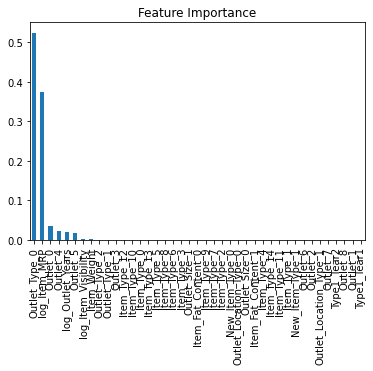

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(bootstrap=True, max_depth=5, max_features=35, n_estimators=1000)
train(model, X_norm, y)
coef = pd.Series(model.feature_importances_, X_norm.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Feature Importance")

## ExtraTreeRegressor

Model Report
MSE: 0.2767243109732031
RMSE: 0.5260459209738282


<Axes: title={'center': 'Feature Importance'}>

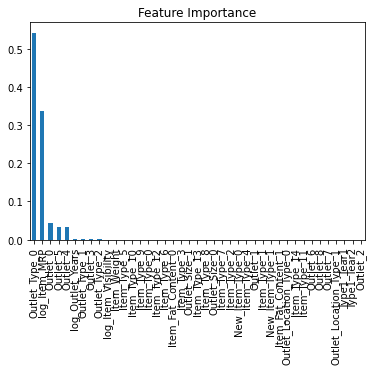

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(bootstrap=True, max_depth=5, max_features=35, n_estimators=1000)
train(model, X_norm, y)
coef = pd.Series(model.feature_importances_, X_norm.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Feature Importance")

## Decision Tree Regressor

Model Report
MSE: 0.2911690150890533
RMSE: 0.5396007923354573


<Axes: title={'center': 'Feature Importance'}>

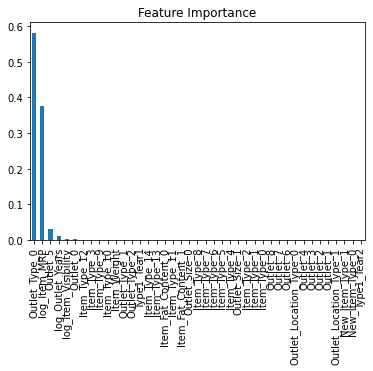

In [ ]:
from sklearn.tree import DecisionTreeRegressor


model =DecisionTreeRegressor(max_depth=5, max_features=35) 
train(model, X_norm, y)
coef = pd.Series(model.feature_importances_, X_norm.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Feature Importance")

## Lasso

Model Report
MSE: 0.2674171383121631
RMSE: 0.5171239100178633


<Axes: title={'center': 'Model Coefficients'}>

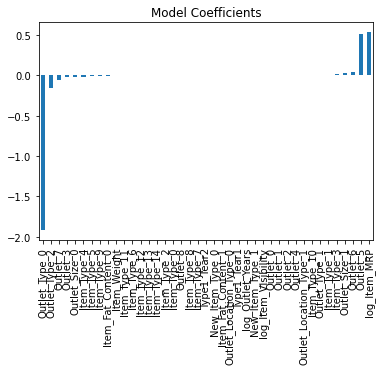

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

model = Lasso(alpha=0.001, tol=0.001)
train(model, X_norm, y)
coef = pd.Series(model.coef_, X_norm.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")

## Ridge

Model Report
MSE: 0.267813850009052
RMSE: 0.5175073429518193


<Axes: title={'center': 'Model Coefficients'}>

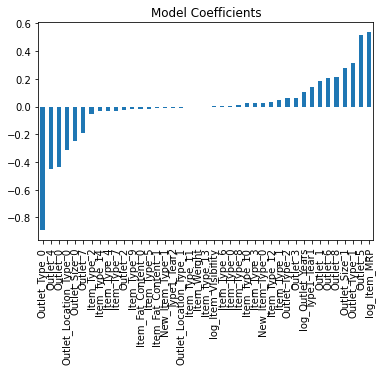

In [ ]:

model = Ridge(alpha=10, max_iter=1000, solver='saga', fit_intercept=True, tol=0.001)

train(model, X_norm, y)
coef = pd.Series(model.coef_, X_norm.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")

## LinearRegression

Model Report
MSE: 0.2678768519450207
RMSE: 0.5175682099443712


<Axes: title={'center': 'Model Coefficients'}>

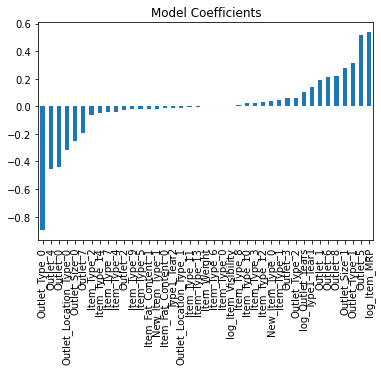

In [ ]:

model = LinearRegression(fit_intercept=True)
train(model, X_norm, y)
coef = pd.Series(model.coef_, X_norm.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")

## SVR

Model Report
MSE: 0.27088285292865005
RMSE: 0.520464074580225


<Axes: title={'center': 'Model Coefficients'}>

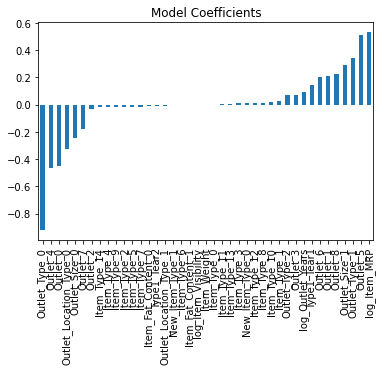

In [ ]:
from sklearn.svm import SVR
model =SVR(C= 0.007, epsilon= 0.005, kernel= 'linear')
train(model, X_norm, y)
#coef = pd.Series(model.coef_, X_norm.columns).sort_values(ascending=False)

coef= model.coef_
#coef.plot(kind='bar', title="Feature Importance")
coef = pd.Series(coef[0], X_norm.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")

In [ ]:
coef= model.coef_[0]
coef

array([-1.31176565e-03, -3.03345684e-03,  5.31172314e-01,  9.27515490e-02,
       -1.08336169e-02, -3.51191960e-03, -2.46919295e-01,  2.88822362e-01,
       -3.22815236e-01, -9.14506983e-03, -9.19301012e-01,  3.40421410e-01,
        7.04197580e-02,  7.91841964e-03, -4.40650005e-03, -4.53002709e-01,
        2.06083413e-01, -3.14923571e-02,  7.04197580e-02, -4.66298303e-01,
        5.08459843e-01,  1.99883469e-01, -1.77536182e-01,  2.24511767e-01,
       -7.93108421e-04,  2.43127002e-02, -1.84972485e-02,  7.65586958e-03,
       -1.91115234e-02, -1.59396450e-02, -3.75666128e-03, -1.52842609e-02,
        1.46848177e-02, -1.87087706e-02,  2.10000000e-02,  5.12033292e-04,
        1.40000000e-02,  2.33544609e-03, -2.04096488e-02,  1.43483067e-01,
       -9.14506983e-03])

## Voting Regressor

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

linear_reg =  LinearRegression(fit_intercept=True)
lasso = Lasso(alpha=0.001, tol=1e-06, fit_intercept=True,max_iter = 1000)
ridge = Ridge(alpha=1, max_iter=1000, solver='saga')

ensemble = VotingRegressor(estimators=[('linear_reg', linear_reg),('lasso', lasso),('ridge',ridge)],n_jobs=1)
weights = [0.2,0.7,0.1]
ensemble.set_params( weights=weights)

train(ensemble,X_norm,y)

      

Model Report
MSE: 0.26746246757045516
RMSE: 0.5171677363974431


In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

tree_reg = RandomForestRegressor(bootstrap=True, max_depth=5, max_features=35, n_estimators=1000)
linear_reg = Lasso(alpha=0.001, tol=1e-06, fit_intercept=True,max_iter = 1000)
extre_reg = ExtraTreesRegressor(bootstrap=True, max_depth=5, max_features=35, n_estimators=1000)
ensemble = VotingRegressor(estimators=[('rf', tree_reg),('lasso', linear_reg),('et',extre_reg)])

# Train the ensemble model on the sample data
ensemble.fit(X_norm, y)
pred = ensemble.predict(X_norm)
cv_score = cross_val_score(ensemble, X_norm, y, scoring='neg_mean_squared_error', cv=5)
cv_score = np.abs(np.mean(cv_score))
    
print("Model Report")
print("MSE:",mean_squared_error(y,pred))
    #print("confusion_matrix:",confusion_matrix(y,pred))
print("CV Score:", cv_score)

Model Report
MSE: 0.26457555650360753
CV Score: 0.2701854583878931
